In [1]:
colab = False
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

import os
import math
import time
import sys
import shutil
import copy
import IPython.display as ipd

import numpy as np

if colab:
  !pip install -q livelossplot
  !pip install -q kaldi_io
  !pip install -q kaldiio
  os.environ['KALDI_ROOT'] = '/content/drive/My Drive/Stage-Imaging/Signal-denoising-in-the-wild'
else:
    os.environ['KALDI_ROOT'] = '/opt/kaldi/'
    
import kaldi_io
import kaldiio
#from livelossplot import PlotLosses
import librosa
from tqdm.notebook import tqdm
#from pesq import pesq

In [2]:
from datasets import SequenceDataset
from utils import ScheduledOptim, change_path_scp, EnergyConservingLoss, plot_modelPerformance, l1_mse_loss, splitAudio

In [3]:
if colab:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device
else:  
  os.environ["CUDA_VISIBLE_DEVICES"] = '3'
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device

In [4]:
train_dataset = SequenceDataset('../data/train/trainTOTAL.scp', '../data/utt2spkTOTAL.scp', min_length = 16000, colab = False)
test_dataset = SequenceDataset('../data/test/testTOTAL.scp', '../data/utt2spkTOTAL.scp', min_length = 16000, colab = False)

Totally 25334 samples with at most 247 samples for one class
Totally 5482 samples with at most 247 samples for one class


In [5]:
train_data = DataLoader(train_dataset, batch_size = 1, shuffle=True)
test_data = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [6]:
import torchaudio

In [8]:
clean, noisy, _ = next(iter(train_data))

In [11]:
clean.squeeze().size()

torch.Size([16000])

In [12]:
torch.stft(noisy.squeeze(), n_fft = 255, win_length = 255,# window = torch.hann_window(window_length = 255),
          hop_length=125).size()

torch.Size([128, 128, 2])

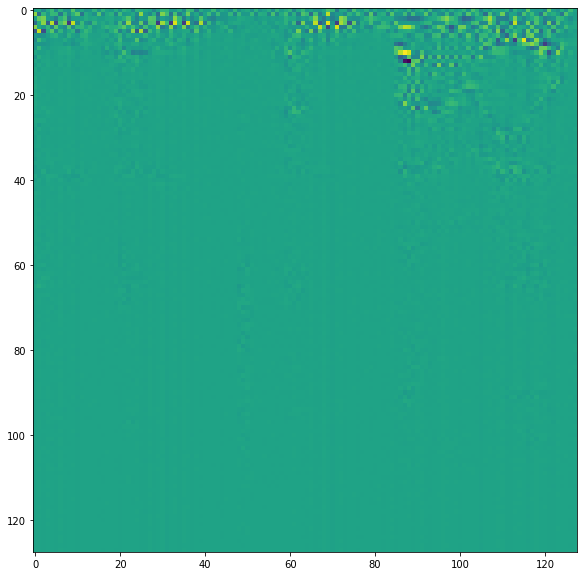

In [171]:
plt.figure(figsize = (10, 10))
plt.imshow(new[:,:,0])

In [13]:
class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out


class Generator128(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Generator128, self).__init__()

        # Encoder
        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4)
        self.conv4 = ConvBlock(num_filter * 4, num_filter * 8)
        self.conv5 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv6 = ConvBlock(num_filter * 8, num_filter * 8)
        self.conv7 = ConvBlock(num_filter * 8, num_filter * 8, batch_norm=False)
        # Decoder
        self.deconv1 = DeconvBlock(num_filter * 8, num_filter * 8, dropout=True)
        self.deconv2 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv3 = DeconvBlock(num_filter * 8 * 2, num_filter * 8, dropout=True)
        self.deconv4 = DeconvBlock(num_filter * 8 * 2, num_filter * 4)
        self.deconv5 = DeconvBlock(num_filter * 4 * 2, num_filter * 2)
        self.deconv6 = DeconvBlock(num_filter * 2 * 2, num_filter)
        self.deconv7 = DeconvBlock(num_filter * 2, output_dim, batch_norm=False)

    def forward(self, x):
        # Encoder
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        # Decoder with skip-connections
        dec1 = self.deconv1(enc7)
        dec1 = torch.cat([dec1, enc6], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc5], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc4], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc3], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc2], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc1], 1)
        dec7 = self.deconv7(dec6)
        out = torch.nn.Tanh()(dec7)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, DeconvBlock):
                torch.nn.init.normal(m.deconv.weight, mean, std)
                
class Discriminator128(torch.nn.Module):
    def __init__(self, input_dim, num_filter, output_dim):
        super(Discriminator128, self).__init__()

        self.conv1 = ConvBlock(input_dim, num_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(num_filter, num_filter * 2)
        self.conv3 = ConvBlock(num_filter * 2, num_filter * 4, stride=1)
        self.conv4 = ConvBlock(num_filter * 4, output_dim, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)
                
                
# Plot losses
def plot_loss(d_losses, g_losses, num_epochs, save=False, save_dir='results/', show=True):
    fig, ax = plt.subplots()
    ax.set_xlim(0, num_epochs)
    ax.set_ylim(0, max(np.max(g_losses), np.max(d_losses))*1.1)
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'Loss_values_epoch_{:d}'.format(num_epochs) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


In [27]:
# Models
G = Generator128(2, 128, 2)
D = Discriminator128(4, 128, 1)
G.cuda()
D.cuda()
G.normal_weight_init(mean=0.0, std=0.02)
D.normal_weight_init(mean=0.0, std=0.02)

# Set the logger
# D_log_dir = save_dir + 'D_logs'
# G_log_dir = save_dir + 'G_logs'
# if not os.path.exists(D_log_dir):
#     os.mkdir(D_log_dir)
# D_logger = Logger(D_log_dir)

# if not os.path.exists(G_log_dir):
#     os.mkdir(G_log_dir)
# G_logger = Logger(G_log_dir)

# Loss function
BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training GAN
D_avg_losses = []
G_avg_losses = []

<ipython-input-13-2b636c1a2bbf>:94: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)
<ipython-input-13-2b636c1a2bbf>:96: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.deconv.weight, mean, std)
<ipython-input-13-2b636c1a2bbf>:119: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.conv.weight, mean, std)


In [32]:
step = 0
for epoch in range(5):
    D_losses = []
    G_losses = []

    # training
    for i, (target, input, _) in enumerate(train_data):

        # input & target image data
        x_ = torch.stft(input.squeeze(), n_fft = 255, win_length = 255, window = torch.hann_window(window_length = 255),
          hop_length=125).unsqueeze(0).reshape((1, 2, 128, 128)).cuda()
        y_ = torch.stft(target.squeeze(), n_fft = 255, win_length = 255, window = torch.hann_window(window_length = 255),
          hop_length=125).unsqueeze(0).reshape((1, 2, 128, 128)).cuda()
        #print(x_.size(), y_.size())

        # Train discriminator with real data
        D_real_decision = D(x_, y_).squeeze()
        real_ = torch.ones(D_real_decision.size()).cuda()
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        fake_ = torch.zeros(D_fake_decision.size()).cuda()
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss = 100 * L1_loss(gen_image, y_)

        # Back propagation
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
              % (epoch+1, 5, i+1, len(train_data), D_loss.item(), G_loss.item()))

        # ============ TensorBoard logging ============#
#         D_logger.scalar_summary('losses', D_loss.data[0], step + 1)
#         G_logger.scalar_summary('losses', G_loss.data[0], step + 1)
#         step += 1

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Show result for test image
#     gen_image = G(Variable(test_input.cuda()))
#     gen_image = gen_image.cpu().data
#     utils.plot_test_result(test_input, test_target, gen_image, epoch, save=True, save_dir=save_dir)

# Plot average losses
plot_loss(D_avg_losses, G_avg_losses, 5, save=False, save_dir=save_dir)

# Make gif
#utils.make_gif(params.dataset, params.num_epochs, save_dir=save_dir)

# Save trained parameters of model
# torch.save(G.state_dict(), model_dir + 'generator_param.pkl')
# torch.save(D.state_dict(), model_dir + 'discriminator_param.pkl')

Epoch [1/5], Step [1/25334], D_loss: 0.7294, G_loss: 25.7622
Epoch [1/5], Step [2/25334], D_loss: 0.7412, G_loss: 9.2083
Epoch [1/5], Step [3/25334], D_loss: 0.6758, G_loss: 13.8910
Epoch [1/5], Step [4/25334], D_loss: 0.7397, G_loss: 7.8289
Epoch [1/5], Step [5/25334], D_loss: 0.6928, G_loss: 17.3188
Epoch [1/5], Step [6/25334], D_loss: 0.6241, G_loss: 9.8831
Epoch [1/5], Step [7/25334], D_loss: 0.7246, G_loss: 12.0516
Epoch [1/5], Step [8/25334], D_loss: 0.6421, G_loss: 11.9514
Epoch [1/5], Step [9/25334], D_loss: 0.6862, G_loss: 23.6577
Epoch [1/5], Step [10/25334], D_loss: 0.7436, G_loss: 6.7836
Epoch [1/5], Step [11/25334], D_loss: 0.6735, G_loss: 10.0622
Epoch [1/5], Step [12/25334], D_loss: 0.7208, G_loss: 6.2098
Epoch [1/5], Step [13/25334], D_loss: 0.7098, G_loss: 5.1032
Epoch [1/5], Step [14/25334], D_loss: 0.6948, G_loss: 8.6789
Epoch [1/5], Step [15/25334], D_loss: 0.6662, G_loss: 6.3705
Epoch [1/5], Step [16/25334], D_loss: 0.9438, G_loss: 5.0320
Epoch [1/5], Step [17/2533

Epoch [1/5], Step [135/25334], D_loss: 0.5983, G_loss: 8.2945
Epoch [1/5], Step [136/25334], D_loss: 0.1439, G_loss: 19.2705
Epoch [1/5], Step [137/25334], D_loss: 0.3317, G_loss: 7.7724
Epoch [1/5], Step [138/25334], D_loss: 0.1441, G_loss: 10.5264
Epoch [1/5], Step [139/25334], D_loss: 1.1265, G_loss: 6.4215
Epoch [1/5], Step [140/25334], D_loss: 0.2507, G_loss: 21.9660
Epoch [1/5], Step [141/25334], D_loss: 0.2390, G_loss: 27.1330
Epoch [1/5], Step [142/25334], D_loss: 0.5343, G_loss: 4.7910
Epoch [1/5], Step [143/25334], D_loss: 0.2574, G_loss: 6.5666
Epoch [1/5], Step [144/25334], D_loss: 0.2068, G_loss: 8.2148
Epoch [1/5], Step [145/25334], D_loss: 0.1820, G_loss: 9.5096
Epoch [1/5], Step [146/25334], D_loss: 0.9118, G_loss: 7.1165
Epoch [1/5], Step [147/25334], D_loss: 0.1542, G_loss: 12.9767
Epoch [1/5], Step [148/25334], D_loss: 0.2956, G_loss: 5.9475
Epoch [1/5], Step [149/25334], D_loss: 0.3866, G_loss: 8.0579
Epoch [1/5], Step [150/25334], D_loss: 0.0954, G_loss: 16.5221
Ep

Epoch [1/5], Step [267/25334], D_loss: 0.0317, G_loss: 17.6813
Epoch [1/5], Step [268/25334], D_loss: 0.1173, G_loss: 7.3410
Epoch [1/5], Step [269/25334], D_loss: 1.0579, G_loss: 5.9651
Epoch [1/5], Step [270/25334], D_loss: 0.2694, G_loss: 6.0780
Epoch [1/5], Step [271/25334], D_loss: 0.0971, G_loss: 9.3624
Epoch [1/5], Step [272/25334], D_loss: 0.5851, G_loss: 4.0565
Epoch [1/5], Step [273/25334], D_loss: 0.0525, G_loss: 11.7829
Epoch [1/5], Step [274/25334], D_loss: 0.0511, G_loss: 12.9159
Epoch [1/5], Step [275/25334], D_loss: 0.0585, G_loss: 13.2522
Epoch [1/5], Step [276/25334], D_loss: 0.0789, G_loss: 15.5879
Epoch [1/5], Step [277/25334], D_loss: 0.0408, G_loss: 15.4976
Epoch [1/5], Step [278/25334], D_loss: 0.0458, G_loss: 10.8296
Epoch [1/5], Step [279/25334], D_loss: 0.1384, G_loss: 34.6628
Epoch [1/5], Step [280/25334], D_loss: 0.2667, G_loss: 6.0647
Epoch [1/5], Step [281/25334], D_loss: 0.0196, G_loss: 16.4618
Epoch [1/5], Step [282/25334], D_loss: 0.1302, G_loss: 14.636

Epoch [1/5], Step [399/25334], D_loss: 0.0203, G_loss: 14.8956
Epoch [1/5], Step [400/25334], D_loss: 1.0954, G_loss: 5.3711
Epoch [1/5], Step [401/25334], D_loss: 0.1155, G_loss: 34.3722
Epoch [1/5], Step [402/25334], D_loss: 0.6076, G_loss: 3.6001
Epoch [1/5], Step [403/25334], D_loss: 0.6027, G_loss: 5.0253
Epoch [1/5], Step [404/25334], D_loss: 0.0331, G_loss: 12.4458
Epoch [1/5], Step [405/25334], D_loss: 0.0413, G_loss: 13.1672
Epoch [1/5], Step [406/25334], D_loss: 0.7856, G_loss: 3.4354
Epoch [1/5], Step [407/25334], D_loss: 0.2246, G_loss: 7.5372
Epoch [1/5], Step [408/25334], D_loss: 0.0763, G_loss: 12.5500
Epoch [1/5], Step [409/25334], D_loss: 0.5760, G_loss: 3.8804
Epoch [1/5], Step [410/25334], D_loss: 0.0341, G_loss: 14.8443
Epoch [1/5], Step [411/25334], D_loss: 0.0295, G_loss: 17.6016
Epoch [1/5], Step [412/25334], D_loss: 0.0541, G_loss: 12.1981
Epoch [1/5], Step [413/25334], D_loss: 0.0160, G_loss: 19.0122
Epoch [1/5], Step [414/25334], D_loss: 0.0176, G_loss: 23.102

Epoch [1/5], Step [531/25334], D_loss: 0.0140, G_loss: 19.8197
Epoch [1/5], Step [532/25334], D_loss: 0.0174, G_loss: 14.4754
Epoch [1/5], Step [533/25334], D_loss: 0.0688, G_loss: 10.0254
Epoch [1/5], Step [534/25334], D_loss: 0.0212, G_loss: 13.9412
Epoch [1/5], Step [535/25334], D_loss: 0.0175, G_loss: 8.0823
Epoch [1/5], Step [536/25334], D_loss: 0.0171, G_loss: 21.2945
Epoch [1/5], Step [537/25334], D_loss: 0.0211, G_loss: 9.3512
Epoch [1/5], Step [538/25334], D_loss: 0.0169, G_loss: 22.5324
Epoch [1/5], Step [539/25334], D_loss: 0.0197, G_loss: 10.6262
Epoch [1/5], Step [540/25334], D_loss: 0.0187, G_loss: 26.4346
Epoch [1/5], Step [541/25334], D_loss: 0.0614, G_loss: 6.4701
Epoch [1/5], Step [542/25334], D_loss: 0.1134, G_loss: 7.5041
Epoch [1/5], Step [543/25334], D_loss: 0.0105, G_loss: 11.8202
Epoch [1/5], Step [544/25334], D_loss: 0.0535, G_loss: 10.8560
Epoch [1/5], Step [545/25334], D_loss: 0.1732, G_loss: 6.8201
Epoch [1/5], Step [546/25334], D_loss: 0.0163, G_loss: 11.76

Epoch [1/5], Step [663/25334], D_loss: 0.0557, G_loss: 7.7283
Epoch [1/5], Step [664/25334], D_loss: 0.0309, G_loss: 7.0874
Epoch [1/5], Step [665/25334], D_loss: 0.5287, G_loss: 6.5886
Epoch [1/5], Step [666/25334], D_loss: 0.1043, G_loss: 8.1978
Epoch [1/5], Step [667/25334], D_loss: 0.0099, G_loss: 10.3656
Epoch [1/5], Step [668/25334], D_loss: 0.1733, G_loss: 6.9648
Epoch [1/5], Step [669/25334], D_loss: 0.0104, G_loss: 20.1014
Epoch [1/5], Step [670/25334], D_loss: 0.0714, G_loss: 12.1616
Epoch [1/5], Step [671/25334], D_loss: 0.0482, G_loss: 8.1864
Epoch [1/5], Step [672/25334], D_loss: 0.0197, G_loss: 8.4603
Epoch [1/5], Step [673/25334], D_loss: 0.0122, G_loss: 13.0085
Epoch [1/5], Step [674/25334], D_loss: 0.0315, G_loss: 8.1363
Epoch [1/5], Step [675/25334], D_loss: 0.1612, G_loss: 7.5543
Epoch [1/5], Step [676/25334], D_loss: 0.0164, G_loss: 29.1799
Epoch [1/5], Step [677/25334], D_loss: 0.0090, G_loss: 15.2098
Epoch [1/5], Step [678/25334], D_loss: 0.3407, G_loss: 7.1332
Ep

Epoch [1/5], Step [795/25334], D_loss: 0.0068, G_loss: 11.4988
Epoch [1/5], Step [796/25334], D_loss: 0.0060, G_loss: 18.1303
Epoch [1/5], Step [797/25334], D_loss: 0.3019, G_loss: 10.5034
Epoch [1/5], Step [798/25334], D_loss: 0.0067, G_loss: 11.8295
Epoch [1/5], Step [799/25334], D_loss: 0.0163, G_loss: 26.2967
Epoch [1/5], Step [800/25334], D_loss: 0.0085, G_loss: 9.3145
Epoch [1/5], Step [801/25334], D_loss: 0.0081, G_loss: 13.2557
Epoch [1/5], Step [802/25334], D_loss: 0.0068, G_loss: 15.5235
Epoch [1/5], Step [803/25334], D_loss: 0.0248, G_loss: 6.7190
Epoch [1/5], Step [804/25334], D_loss: 0.0086, G_loss: 11.6254
Epoch [1/5], Step [805/25334], D_loss: 0.0051, G_loss: 16.9124
Epoch [1/5], Step [806/25334], D_loss: 0.0061, G_loss: 15.8915
Epoch [1/5], Step [807/25334], D_loss: 0.0417, G_loss: 39.2384
Epoch [1/5], Step [808/25334], D_loss: 0.0241, G_loss: 7.2870
Epoch [1/5], Step [809/25334], D_loss: 0.0077, G_loss: 13.5596
Epoch [1/5], Step [810/25334], D_loss: 0.0528, G_loss: 6.0

Epoch [1/5], Step [927/25334], D_loss: 0.0037, G_loss: 16.0770
Epoch [1/5], Step [928/25334], D_loss: 0.0040, G_loss: 17.5973
Epoch [1/5], Step [929/25334], D_loss: 0.0110, G_loss: 11.6306
Epoch [1/5], Step [930/25334], D_loss: 0.0039, G_loss: 15.6204
Epoch [1/5], Step [931/25334], D_loss: 0.0316, G_loss: 9.9939
Epoch [1/5], Step [932/25334], D_loss: 0.0051, G_loss: 18.2558
Epoch [1/5], Step [933/25334], D_loss: 0.0027, G_loss: 12.2481
Epoch [1/5], Step [934/25334], D_loss: 0.0024, G_loss: 14.6845
Epoch [1/5], Step [935/25334], D_loss: 0.0027, G_loss: 11.8380
Epoch [1/5], Step [936/25334], D_loss: 0.0051, G_loss: 11.2928
Epoch [1/5], Step [937/25334], D_loss: 0.0089, G_loss: 35.1408
Epoch [1/5], Step [938/25334], D_loss: 0.1656, G_loss: 7.7669
Epoch [1/5], Step [939/25334], D_loss: 0.0099, G_loss: 10.6555
Epoch [1/5], Step [940/25334], D_loss: 0.0050, G_loss: 14.5952
Epoch [1/5], Step [941/25334], D_loss: 0.0456, G_loss: 8.5349
Epoch [1/5], Step [942/25334], D_loss: 0.0325, G_loss: 7.2

Epoch [1/5], Step [1057/25334], D_loss: 0.0073, G_loss: 17.5457
Epoch [1/5], Step [1058/25334], D_loss: 0.0097, G_loss: 8.3540
Epoch [1/5], Step [1059/25334], D_loss: 0.0218, G_loss: 5.7741
Epoch [1/5], Step [1060/25334], D_loss: 0.0143, G_loss: 21.4366
Epoch [1/5], Step [1061/25334], D_loss: 0.0136, G_loss: 11.8310
Epoch [1/5], Step [1062/25334], D_loss: 0.0666, G_loss: 10.9619
Epoch [1/5], Step [1063/25334], D_loss: 0.0033, G_loss: 20.2923
Epoch [1/5], Step [1064/25334], D_loss: 0.0053, G_loss: 15.7082
Epoch [1/5], Step [1065/25334], D_loss: 0.2916, G_loss: 3.3099
Epoch [1/5], Step [1066/25334], D_loss: 0.0434, G_loss: 8.5029
Epoch [1/5], Step [1067/25334], D_loss: 0.2472, G_loss: 6.8631
Epoch [1/5], Step [1068/25334], D_loss: 0.1950, G_loss: 15.1086
Epoch [1/5], Step [1069/25334], D_loss: 0.3709, G_loss: 6.8670
Epoch [1/5], Step [1070/25334], D_loss: 0.0300, G_loss: 12.2841
Epoch [1/5], Step [1071/25334], D_loss: 0.0452, G_loss: 11.6085
Epoch [1/5], Step [1072/25334], D_loss: 0.2170

KeyboardInterrupt: 

In [173]:
net

Generator(
  (conv1): ConvBlock(
    (conv): Conv2d(2, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): ConvBlock(
    (conv): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, tra

In [174]:
prova = torch.rand((1, 2, 128, 128))

In [175]:
net(prova).size()

torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 1024, 1, 1])


torch.Size([1, 2, 128, 128])

In [123]:
import math

import torch
from torch import nn
from torch.nn import functional as F


class ResidualConv1dGLU(nn.Module):
    """Residual dilated conv1d + Gated linear unit
    Args:
        residual_channels (int): Residual input / output channels
        gate_channels (int): Gated activation channels.
        kernel_size (int): Kernel size of convolution layers.
        skip_out_channels (int): Skip connection channels. If None, set to same
          as ``residual_channels``.
        cin_channels (int): Local conditioning channels. If negative value is
          set, local conditioning is disabled.
        gin_channels (int): Global conditioning channels. If negative value is
          set, global conditioning is disabled.
        dropout (float): Dropout probability.
        padding (int): Padding for convolution layers. If None, proper padding
          is computed depends on dilation and kernel_size.
        dilation (int): Dilation factor.
    """

    def __init__(self, residual_channels, gate_channels, kernel_size,
                 skip_out_channels=None,
                 cin_channels=-1, gin_channels=-1,
                 dropout=1 - 0.95, padding=None, dilation=1,
                 bias=True, *args, **kwargs):
        super(ResidualConv1dGLU, self).__init__()
        self.dropout = dropout
        if skip_out_channels is None:
            skip_out_channels = residual_channels
        if padding is None:
            padding = (kernel_size - 1) // 2 * dilation

        self.conv = nn.Conv1d(residual_channels, gate_channels, kernel_size,
                              padding=padding, dilation=dilation,
                              bias=bias, *args, **kwargs)

        # local conditioning
        if cin_channels > 0:
            self.conv1x1c = nn.Conv1d(cin_channels, gate_channels, 1, bias=bias)
        else:
            self.conv1x1c = None

        # global conditioning
        if gin_channels > 0:
            self.conv1x1g = nn.Conv1d(gin_channels, gate_channels, 1, bias=bias)

        else:
            self.conv1x1g = None

        # conv output is split into two groups
        gate_out_channels = gate_channels // 2
        self.conv1x1_out = nn.Conv1d(gate_out_channels, residual_channels, 1, bias=bias)
        self.conv1x1_skip = nn.Conv1d(gate_out_channels, skip_out_channels, 1, bias=bias)

    def forward(self, x, c=None, g=None):
        """Forward
        Args:
            x (Tensor): B x C x T
            c (Tensor): B x C x T, Local conditioning features
            g (Tensor): B x C x T, Expanded global conditioning features
        Returns:
            Tensor: output
        """
        residual = x
        x = F.dropout(x, p=self.dropout, training=self.training)
        splitdim = 1
        x = self.conv(x)

        a, b = x.split(x.size(splitdim) // 2, dim=splitdim)

        # local conditioning
        if c is not None:
            assert self.conv1x1c is not None
            c = self.conv1x1c(c)
            ca, cb = c.split(c.size(splitdim) // 2, dim=splitdim)
            a, b = a + ca, b + cb

        # global conditioning
        if g is not None:
            assert self.conv1x1g is not None
            g = self.conv1x1g(g)
            ga, gb = g.split(g.size(splitdim) // 2, dim=splitdim)
            a, b = a + ga, b + gb

        x = torch.tanh(a) * torch.sigmoid(b)

        # For skip connection
        s = self.conv1x1_skip(x)

        # For residual connection
        x = self.conv1x1_out(x)

        x = (x + residual) * math.sqrt(0.5)
        return x, s


class DWaveNet(nn.Module):
    def __init__(self, in_channels, out_channels=1, bias=False,
                 num_layers=30, num_stacks=3,
                 kernel_size=3,
                 residual_channels=128, gate_channels=128, skip_out_channels=128,
                 last_channels=(2048, 256),
                 ):
        super().__init__()
        assert num_layers % num_stacks == 0
        num_layers_per_stack = num_layers // num_stacks
        self.l_diff = num_stacks * (2**num_layers_per_stack - 1)

        self.first_conv = nn.Conv1d(in_channels, residual_channels, 3, padding=1, bias=bias)

        self.conv_layers = nn.ModuleList()
        for n_layer in range(num_layers):
            dilation = 2**(n_layer % num_layers_per_stack)
            conv = ResidualConv1dGLU(
                residual_channels, gate_channels,
                skip_out_channels=skip_out_channels,
                kernel_size=kernel_size,
                bias=bias,
                dilation=dilation,
                dropout=1 - 0.95,
            )
            self.conv_layers.append(conv)

        self.last_conv_layers = nn.Sequential(
            nn.ReLU(True),
            nn.Conv1d(skip_out_channels, last_channels[0], 3, padding=1, bias=bias),
            nn.ReLU(True),
            nn.Conv1d(last_channels[0], last_channels[1], 3, padding=1, bias=bias),
            nn.Conv1d(last_channels[1], out_channels, 1, bias=True)
        )

    def forward(self, x):
        x = self.first_conv(x)
        skips = None
        for conv in self.conv_layers:
            x, h = conv(x)
            if skips is None:
                skips = h#[..., self.l_diff:-self.l_diff]
            else:
                skips += h#[..., self.l_diff:-self.l_diff]

        x = skips
        x = self.last_conv_layers(x)

        return x

In [132]:
2**(16%10)

64

In [137]:
13%10

3

In [124]:
net = DWaveNet(in_channels = 1)

In [117]:
3*(2**10 -1)

3069

In [125]:
prova = torch.randn((1, 1, 16000))

In [119]:
prova.size()

torch.Size([1, 1, 8000])

In [126]:
net(prova).size()

RuntimeError: The size of tensor a (16004) must match the size of tensor b (16000) at non-singleton dimension 2

In [ ]:
conv = ResidualConv1dGLU()